In [1]:
%run srcnn.py

/home/montero/.conda/envs/my_root/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


In [31]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

%matplotlib inline
from PIL import Image, ImageFilter
import math
from os import listdir
import random
import cv2

import pywt

K.tensorflow_backend.set_session(tf.Session(config=config))



In [2]:
print(device_lib.list_local_devices())
print(K.tensorflow_backend._get_available_gpus())

session = tf.Session(config=config)
keras.backend.set_session(session)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17483359832587498333
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10998149940
locality {
  bus_id: 1
}
incarnation: 13231022806371616310
physical_device_desc: "device: 0, name: GeForce GTX TITAN X, pci bus id: 0000:04:00.0, compute capability: 5.2"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 11942933300
locality {
  bus_id: 2
}
incarnation: 16461387357972094313
physical_device_desc: "device: 1, name: GeForce GTX TITAN X, pci bus id: 0000:83:00.0, compute capability: 5.2"
]
['/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1']


### Load images

In [3]:
def convertToYCbCr(x):
    return [image.convert('YCbCr') for image in x]

In [4]:
#Display images
def print_luminance(img, ch=1) :
    if (ch == 1) :
        plt.imshow(img, cmap=plt.get_cmap('gray'), interpolation='nearest')
    else :
        plt.imshow(img[:,:,0], cmap=plt.get_cmap('gray'), interpolation='nearest')

In [5]:
PATH = ""
TRAIN_FILE = PATH + "datasets/DIV2K_train_HR/"
obj_files = listdir(TRAIN_FILE )

In [6]:
len(obj_files)

496

In [7]:
#Load images

obj_img = []
train_img = []
valid_hr_img = []
valid_lr_img= []

for i in range(0,90):
    n = obj_files[i]
    obj_img.append(Image.open(TRAIN_FILE + n))

In [8]:
#Convert images to numpy array
rgb_hd = [np.asarray(image) for image in obj_img]

(2040, 1356, 3)


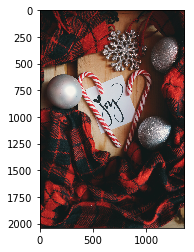

In [10]:
print(rgb_hd[0].shape)
plt.imshow(rgb_hd[0])

### Generate train and test set

In [11]:
def getSubImage(img, height, width, centerX, centerY, len_interval, scale = 1) :
    window = window_size // scale
    return img[ height   : height//2 + window + centerX*len_interval,
                width // 2  + centerY*len_interval : width//2 + window + centerY*len_interval : ]

In [17]:
def retSize(x):
    return (x.shape[0], x.shape[1])

In [10]:
#Division by 4
window_size= 64
scale = 4
stride = 30

In [117]:
def getSubImages(image, stride = stride) :
    sub = []
    height, width = utility.getSize(image)
    for h in range(0, height - window_size, stride) :
        for w in range (0, width - window_size, stride) : 
            sub.append(image[h : h + window_size, w : w + window_size, :])
    return sub

In [12]:
rgb_hd[i].shape

(1356, 2040, 3)

In [16]:
img_len = 90

sub_labels = []
sub_samples = []
sub_valid_hr = []
sub_valid_lr = []

for i in range(0,img_len) :
    label, sample = get_input_images(rgb_hd[i], 4)
    
    #Calculate subimages
    sub_labels += getSubImages(label)
    sub_samples += getSubImages(sample)

sub_samples = [sub_sample / 255. for sub_sample in sub_samples]
sub_labels = [sub_labels / 255. for sub_labels in sub_labels]

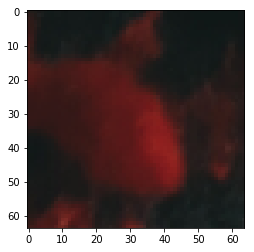

In [17]:
plt.imshow(sub_labels[10])

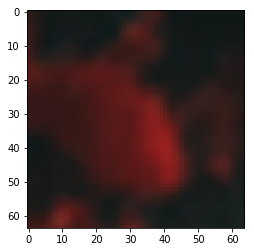

In [18]:
plt.imshow(sub_samples[10])

#### Generate the wavelets subbands

In [19]:
def appendSubbands(l1,l2,l3,l4, dwt):
    l1 = np.append(l1 , dwt[0])
    l2 = np.append(l2, dwt[1][0])
    l3 = np.append(l3, dwt[1][1])
    l4 = np.append(l4, dwt[1][2])
    return (l1,l2,l3,l4)

In [20]:
def plot4images(im1, im2, im3, im4, ch=1) :
    size = (10, 10)
    fig = plt.figure(figsize=size)
    
    plt.subplot(221)
    plt.title("Approximation")
    print_luminance(im1, ch )
    plt.subplot(222)
    plt.title("Horizontal")
    print_luminance(im2, ch)
    plt.subplot(223)
    plt.title("Vertical")
    print_luminance(im3, ch)
    
    plt.subplot(224)
    plt.title("Diagonal")
    print_luminance(im4, ch)

def plot_waveletTrans(wt, ch=1) :
    plot4images(wt[0], wt[1][0], wt[1][1], wt[1][2], ch)

In [21]:
x_sample = sub_samples[20][:,:,0]
x_dwt = pywt.dwt2(x_sample, 'haar')
x_dwt[0].shape

(32, 32)

(32, 32)


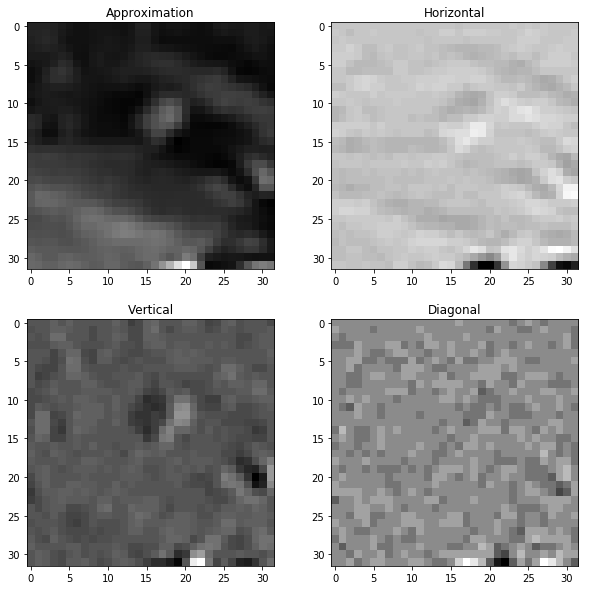

In [22]:
x_sample = sub_samples[20][:,:,0]
x_dwt = pywt.dwt2(x_sample, 'haar')
print(x_dwt[0].shape)
plot_waveletTrans(x_dwt)

0.619607843137


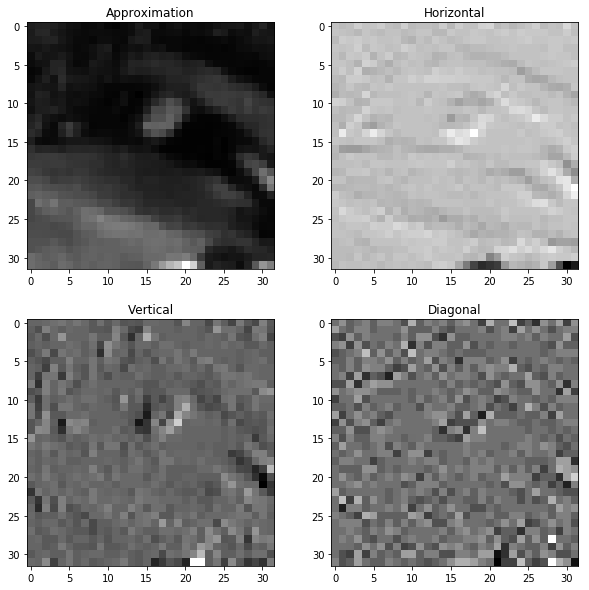

In [23]:
y_sample = sub_labels[20][:,:,0]
y_dwt = pywt.dwt2(y_sample, 'haar')
print(y_dwt[0].max())
plot_waveletTrans(y_dwt)

In [26]:
def get_wavelets(labels, samples, ch_number) :
    assert (ch_number >= 0 and ch_number < 3)
    
    label_set = [] 
    train_set = []
    for i in range(len(labels)) :
        x = samples[i][:,:,ch_number]
        y = labels[i][:,:,ch_number]
    
    
        dwt_y = pywt.dwt2(y, 'haar')
        dwt_x = pywt.dwt2(x, 'haar')    
    
    
        dwt_hd = np.asfarray([dwt_y[0], dwt_y[1][0], dwt_y[1][1], dwt_y[1][2]])
        
        dwt_lw = np.asfarray([dwt_x[0], dwt_x[1][0], dwt_x[1][1], dwt_x[1][2]])    
        label = dwt_hd - dwt_lw
        
        label_set.append(label)
        train_set.append(dwt_lw)
    
    index = np.random.permutation(len(label_set))
    
    label_set = np.asarray(label_set)
    train_set = np.asarray(train_set)
    
    return label_set[index], train_set[index]

In [27]:
def get_channels(img) :
    return img[:,:,0], img[:,:,1], img[:,:,2]

In [26]:
test_red, train_red = get_wavelets(sub_labels, sub_samples, 0)
test_green, train_green = get_wavelets(sub_labels, sub_samples, 1)
test_blue, train_blue = get_wavelets(sub_labels, sub_samples, 2)

In [27]:
train_red.shape

(263736, 4, 32, 32)

In [28]:
test_green.shape

(263736, 4, 32, 32)

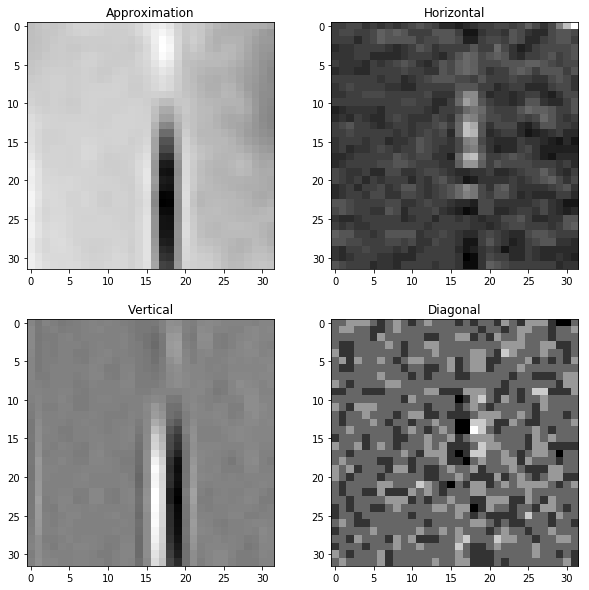

In [29]:
sample = train_red[20]
plot4images(sample[0], sample[1], sample[2], sample[3])

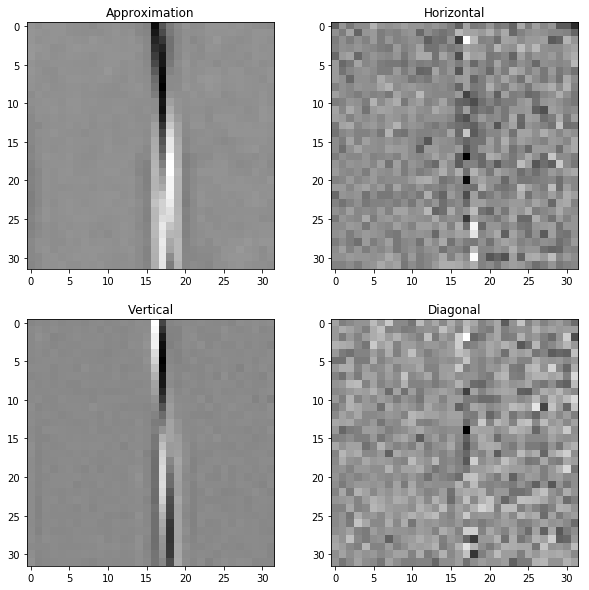

In [30]:
label = test_red[20]
plot4images(label[0], label[1], label[2], label[3])

#### Creating and Training the networks

In [31]:
def reshape(matrix, dwt_shape, channel='channels_last', ch=1) :
    if (channel == 'channels_last') :
        return matrix.reshape(-1, dwt_shape[0], dwt_shape[1], ch)
    else :
        return matrix.reshape(ch, -1, dwt_shape[0], dwt_shape[1])

In [32]:
input_shape = train_red.shape
shape_ = (input_shape[1],input_shape[2], input_shape[3])
shape_

(4, 32, 32)

In [44]:
kernel_ini = initializers.RandomNormal(mean=0.0, stddev=1e-3)
bias_ini = keras.initializers.Zeros()

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8) 

In [52]:
def wavelet_mode () :
    model = Sequential()
    
    model.add(Conv2D(64, kernel_size=(5,5),strides=(1,1),padding='same',
                 activation='relu',
                 input_shape=shape_,
                 kernel_initializer=initializers.RandomNormal(stddev=np.sqrt(2.0/9)),
                 bias_initializer=bias_ini,
                 data_format='channels_first'))
    for i in range(10) :
        model.add(Conv2D(64,
                     kernel_size=(3, 3),
                     strides=(1,1), 
                     activation='relu', 
                     padding='same', 
                     kernel_initializer=initializers.RandomNormal(stddev=np.sqrt(2.0/9/64)),
                     bias_initializer=bias_ini, data_format='channels_first'))

    
    model.add(Conv2D(4, 
                 kernel_size=(3, 3),
                 strides=(1,1), 
                 padding='same', 
                 kernel_initializer=initializers.RandomNormal(stddev=np.sqrt(2.0/9/64)),
                 bias_initializer=bias_ini, data_format='channels_first'))

    model.compile(optimizer=optimizers.Adam(),
             loss='mse')

    return model

In [78]:
def fit_model(model, train, test) :
    model.fit(train, test, validation_split=0.20, epochs=50, batch_size=64, verbose=1)

In [80]:
red_model = wavelet_mode()
fit_model(red_model, train_red, test_red)

Train on 210988 samples, validate on 52748 samples
Epoch 1/20
210988/210988 [==============================] - 162s 769us/step - loss: 0.0040 - val_loss: 0.0036
Epoch 2/20
210988/210988 [==============================] - 162s 769us/step - loss: 0.0035 - val_loss: 0.0035
Epoch 3/20
210988/210988 [==============================] - 160s 761us/step - loss: 0.0035 - val_loss: 0.0035
Epoch 4/20
210988/210988 [==============================] - 158s 748us/step - loss: 0.0034 - val_loss: 0.0034
Epoch 5/20
210988/210988 [==============================] - 160s 758us/step - loss: 0.0034 - val_loss: 0.0034
Epoch 6/20
210988/210988 [==============================] - 160s 760us/step - loss: 0.0033 - val_loss: 0.0034
Epoch 7/20
210988/210988 [==============================] - 160s 760us/step - loss: 0.0033 - val_loss: 0.0034
Epoch 8/20
210988/210988 [==============================] - 161s 763us/step - loss: 0.0033 - val_loss: 0.0033
Epoch 9/20
210988/210988 [==============================] - 162s 767u

In [81]:
green_model = wavelet_mode()
fit_model(green_model, train_green, test_green)


Train on 210988 samples, validate on 52748 samples
Epoch 1/20
210988/210988 [==============================] - 163s 773us/step - loss: 0.0038 - val_loss: 0.0035
Epoch 2/20
210988/210988 [==============================] - 165s 783us/step - loss: 0.0035 - val_loss: 0.0035
Epoch 3/20
210988/210988 [==============================] - 163s 774us/step - loss: 0.0034 - val_loss: 0.0034
Epoch 4/20
210988/210988 [==============================] - 164s 776us/step - loss: 0.0034 - val_loss: 0.0034
Epoch 5/20
210988/210988 [==============================] - 163s 772us/step - loss: 0.0033 - val_loss: 0.0034
Epoch 6/20
210988/210988 [==============================] - 163s 773us/step - loss: 0.0033 - val_loss: 0.0033
Epoch 7/20
210988/210988 [==============================] - 163s 774us/step - loss: 0.0033 - val_loss: 0.0033
Epoch 8/20
210988/210988 [==============================] - 163s 774us/step - loss: 0.0033 - val_loss: 0.0033
Epoch 9/20
210988/210988 [==============================] - 163s 772u

In [82]:
blue_model = wavelet_mode()
fit_model(blue_model, train_blue, test_blue)

Train on 210988 samples, validate on 52748 samples
Epoch 1/20
210988/210988 [==============================] - 164s 779us/step - loss: 0.0052 - val_loss: 0.0033
Epoch 2/20
210988/210988 [==============================] - 166s 788us/step - loss: 0.0032 - val_loss: 0.0032
Epoch 3/20
210988/210988 [==============================] - 166s 788us/step - loss: 0.0032 - val_loss: 0.0032
Epoch 4/20
210988/210988 [==============================] - 169s 801us/step - loss: 0.0032 - val_loss: 0.0032
Epoch 5/20
210988/210988 [==============================] - 168s 796us/step - loss: 0.0031 - val_loss: 0.0031
Epoch 6/20
210988/210988 [==============================] - 165s 782us/step - loss: 0.0031 - val_loss: 0.0031
Epoch 7/20
210988/210988 [==============================] - 164s 779us/step - loss: 0.0031 - val_loss: 0.0031
Epoch 8/20
210988/210988 [==============================] - 166s 788us/step - loss: 0.0031 - val_loss: 0.0031
Epoch 9/20
210988/210988 [==============================] - 164s 775u

In [84]:
save_model(red_model, "SRCNN_red_channel")
save_model(green_model, "SRCNN_green_channel")
save_model(blue_model, "SRCNN_blue_channel")

In [35]:
red_model = load_model("SRCNN_red_channel")
green_model = load_model("SRCNN_green_channel")
blue_model = load_model("SRCNN_blue_channel")

In [36]:
red_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_85 (Conv2D)           (None, 64, 32, 32)        6464      
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 64, 32, 32)        36928     
_________________________________________________________________
conv2d_87 (Conv2D)           (None, 64, 32, 32)        36928     
_________________________________________________________________
conv2d_88 (Conv2D)           (None, 64, 32, 32)        36928     
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 64, 32, 32)        36928     
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 64, 32, 32)        36928     
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 64, 32, 32)        36928     
__________

#### Original image and bicubic interpolated image

In [131]:
def patchs_to_image(patches, height, width, strides=stride) :
    count = 0
    window_size = 64
    
    img = np.zeros((height, width, 3), dtype='uint8')
    
    for h in range(0, height - window_size, strides) :
        for w in range (0, width - window_size, strides) : 
            img[h : h + window_size, w : w + window_size] = patches[count]
            count = count + 1
        
    assert(len(patches) == count)
    return img

In [14]:
valid_folder = "datasets/SR_Test/Set5/"

In [15]:
valid = listdir(valid_folder)
index = 3

In [113]:
im = Image.open(valid_folder + "/" + valid[index])
img = np.asarray(im)

org, bic = get_input_images(img, 4)

h, w = utility.getSize(org)
org.shape

(256, 256, 3)

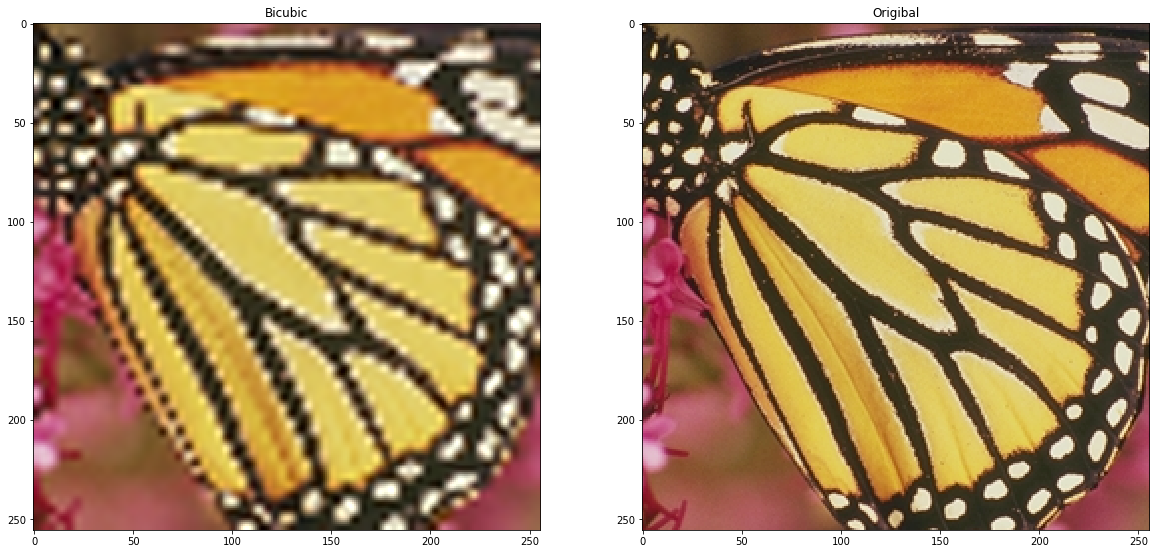

In [19]:
plot_images([org, bic], ["Origibal", "Bicubic"], size=(20, 10), ch=3)

In [211]:
stride = 10
sub_img = getSubImages(bic, stride)
sub_img = [img.astype(float) / 255. for img in sub_img]
sub_img[0].shape

(64, 64, 3)

In [212]:
def get_wavelets(img) :
    
    dwt = pywt.dwt2(img, 'haar')
    
    dwt = np.asfarray([dwt[0], dwt[1][0], dwt[1][1], dwt[1][2]])
        
    return dwt

In [213]:
red_wavelets = np.zeros((len(sub_img), 4, 32, 32))
green_wavelets = np.zeros((len(sub_img), 4, 32, 32))
blue_wavelets = np.zeros((len(sub_img), 4, 32, 32))

for i in range(len(sub_img)) :
    ch_red, ch_green, ch_blue = get_channels(sub_img[i])
    
    red_wavelets[i] = get_wavelets(ch_red)
    green_wavelets[i] = get_wavelets(ch_green)
    blue_wavelets[i] = get_wavelets(ch_blue)


In [214]:
blue_wavelets.shape

(400, 4, 32, 32)

In [215]:
pred_red = red_model.predict(red_wavelets)
pred_blue = blue_model.predict(blue_wavelets)
pred_green = green_model.predict(green_wavelets)



In [216]:
def iwavelet(patch, max_value=255) :
    dwt = (patch[0], (patch[1], patch[2], patch[3]))
    inverse = pywt.idwt2(dwt, 'haar')
    return np.clip(inverse, 0, inverse.max())

In [217]:
red = red_wavelets + pred_red
green = green_wavelets + pred_green
blue = blue_wavelets + pred_blue

sub_imgs = np.zeros((len(red), window_size, window_size, 3))
for i in range(len(red)) :    
    sub_imgs[i,:,:,2] = iwavelet(blue[i])*255.
    sub_imgs[i,:,:,0] = iwavelet(red[i])*255.
    sub_imgs[i,:,:,1] = iwavelet(green[i])*255.

sub_imgs = sub_imgs.astype('uint8')

In [218]:
sub_imgs.shape

(400, 64, 64, 3)

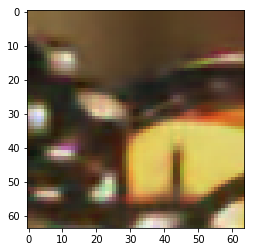

In [219]:
plt.imshow(sub_imgs[1])

In [220]:
im = patchs_to_image(sub_imgs, h, w, stride)

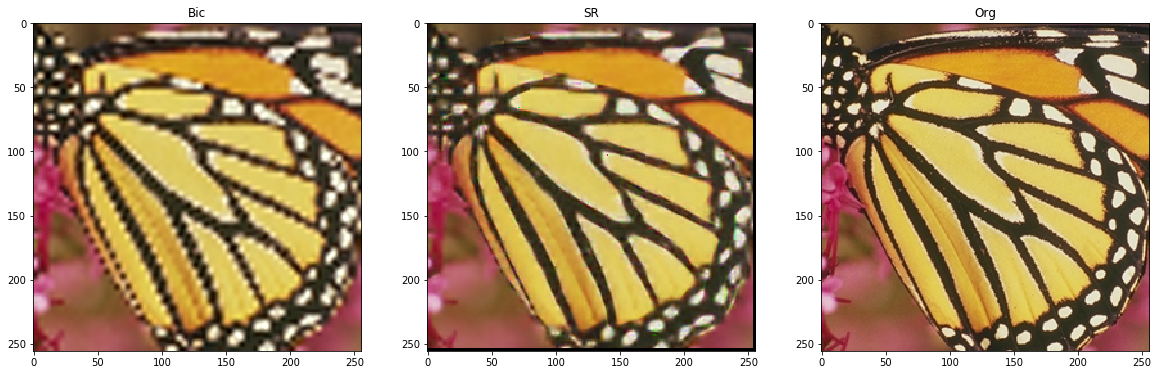

In [221]:
plot_images ([org, bic, im], ["Org", "Bic", "SR"], size= (20,20)) 

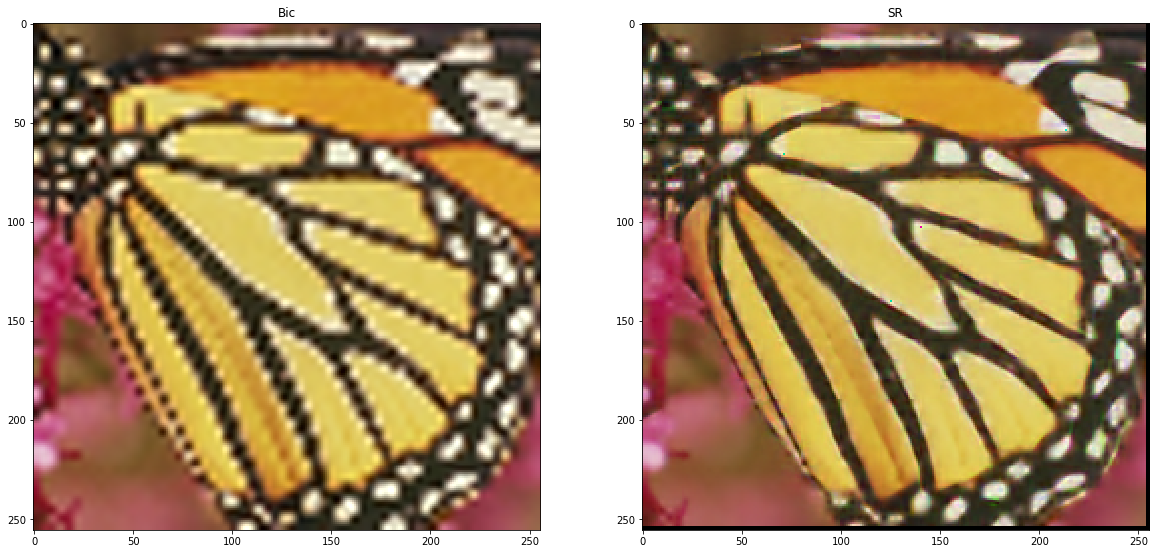

In [222]:
plot_images ([im, bic], ["SR", "Bic"], size= (20,20), ch=3) 